# 1 - NER PyTorch


**Sources** :
- Source de données Kaggle : https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus
- Tuto Abishek : https://www.youtube.com/watch?v=MqQ7rqRllIc

**TODO**
- [x] changer le padding par une autre valeur -> pas besoin en définitive.
- [x] set num workers (minitrain, valid et test)
- [x] peut-on monter la taille des batchs ?
- [x] stratifier les splits
- [x] enregistrer la running loss
- [ ] est-on sûr que les special tokens ne contribuent pas à la loss ?
- [ ] vérifier que le code <a href="https://www.kaggle.com/code/abhishek/entity-extraction-model-using-bert-pytorch">ici</a> est le bon
- [ ] gradual unfreezing
- [ ] early stopping avec lightning
- [ ] POS des mots autour
- [ ] wandb

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import joblib
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

os.chdir('..')

from ner_pytorch.config.params import PARAMS
from ner_pytorch.dataset import EntityDataset
from ner_pytorch.engine import eval_fn, train_fn
from ner_pytorch.model import EntityModel
from ner_pytorch.preprocessing import process_data
from ner_pytorch.utils import *

I0726 18:42:53.989986 140089878529856 modeling.py:230] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


## Chargement des données

In [5]:
data = pd.read_csv(PARAMS.PATHS_EN.TRAIN, encoding='latin-1').drop('POS', axis=1)
data["Sentence #"] = data["Sentence #"].fillna(method='ffill')
data.head(7)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo


En réalité, nous ne nous intéressons qu'à la prédiction des ORG, pour lesquelles 3 labels sont possibles :
- B-org
- I-org
- O

In [6]:
data['Tag'] = data.Tag.mask(~data.Tag.isin(['B-org', 'I-org', 'O']), 'O')
data.Tag.value_counts(normalize=True)

O        0.964784
B-org    0.019210
I-org    0.016006
Name: Tag, dtype: float64

In [7]:
num_tag = data.Tag.nunique()
print(f'Tag {num_tag} categories :', data.Tag.unique(), end='\n\n')

data.shape
data[153:160]

Tag 3 categories : ['O' 'B-org' 'I-org']



(1048575, 3)

,Sentence #,Word,Tag
153,Sentence: 8,The,O
154,Sentence: 8,International,B-org
155,Sentence: 8,Atomic,I-org
156,Sentence: 8,Energy,I-org
157,Sentence: 8,Agency,I-org
158,Sentence: 8,is,O
159,Sentence: 8,to,O


In [5]:
sentences, tag, ordinal_enc_NER = process_data(data)
joblib.dump(ordinal_enc_NER, 'data/outputs/ordinal_enc_NER.joblib')

['data/outputs/ordinal_enc_NER.joblib']

In [6]:
# Démo : 
i = 10
print(sentences[i], end='\n')
print(tag[i], end='\n')
print(ordinal_enc_NER.categories_, end='\n')

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'Fouad', 'Siniora', 'said', 'the', 'Lebanese', 'people', 'are', 'resolute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[array(['O', 'B-org', 'I-org'], dtype=object)]


## Split du jeu de données
On split notre jeu de données de la façon suivante :
- `test` = 20%
- `train` = [`minitrain`, `valid`] = 80%
- `minitrain` = 60%
- `valid` = 20%

In [7]:
len_test = int(PARAMS.SAMPLE_SIZES.TEST * len(sentences))
len_valid = int(PARAMS.SAMPLE_SIZES.VALID * len(sentences))
autre = ordinal_enc_NER.transform([['O']]).item()

# En présence d'un jeu déséquilibré, il vaut mieux stratifier :
strat_tag = [len([_ for _ in tag[i] if _ != autre]) > 0 for i in range(len(tag))]
(
    sentences_train, sentences_test,
    tag_train, tag_test
) = train_test_split(sentences, tag, random_state=PARAMS.SEED, 
                     test_size=len_test, stratify=strat_tag, shuffle=True)

strat_tag_train = [len([_ for _ in tag_train[i] if _ != autre]) > 0 for i in range(len(tag_train))]
(
    sentences_minitrain, sentences_valid,
    tag_minitrain, tag_valid
) = train_test_split(sentences_train, tag_train, random_state=PARAMS.SEED, 
                     test_size=len_valid, stratify=strat_tag_train, shuffle=True)

# Pour se rassurer sur la bonne représentativité de chaque classe dans les échantillons stratifiés : 
pd.Series(np.concatenate(tag_train)).value_counts(normalize=True)
pd.Series(np.concatenate(tag_valid)).value_counts(normalize=True)

len(sentences_minitrain), len(sentences_valid), len(sentences_test)

0.0    0.964808
1.0    0.019224
2.0    0.015968
dtype: float64

0.0    0.965036
1.0    0.018949
2.0    0.016014
dtype: float64

(28777, 9591, 9591)

In [8]:
minitrain_dataset = EntityDataset(
    texts=sentences_minitrain, tags=tag_minitrain
)
minitrain_data_loader = DataLoader(
    minitrain_dataset, batch_size=PARAMS.MODEL.TRAIN_BATCH_SIZE, num_workers=16 
)

valid_dataset = EntityDataset(
    texts=sentences_valid, tags=tag_valid
)
valid_data_loader = DataLoader(
    valid_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

test_dataset = EntityDataset(
    texts=sentences_test, tags=tag_test
)
test_data_loader = DataLoader(
    test_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

In [9]:
i = 40
print(test_dataset.texts[i])
for key, value in test_dataset[i].items():
    print(key + ':', value)

['The', 'Spanish', 'troops', 'will', 'join', 'the', 'European', 'Union', 'force', 'sent', 'to', 'protect', 'ships', 'against', 'hijackings', 'and', 'attacks', 'by', 'Somali', 'pirates', '.']
ids: tensor([  101,  1996,  3009,  3629,  2097,  3693,  1996,  2647,  2586,  2486,
         2741,  2000,  4047,  3719,  2114,  7632, 17364,  8613,  1998,  4491,
         2011, 16831,  8350,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

## Expériences pré-entraînement

Avant de lancer le modèle, quelle _loss_ serait considérée comme statisfaisante ? Calculons à l'avance les loss que donneraient :

- un modèle qui prédit aléatoirement 
- un modèle qui prédit la classe modale ("O")
- un modèle qui prédit de façon satisfaisante, avec une accuracy donnée*
- un modèle oracle (prédiction parfaite)

*Remarque : pour deux modèles qui produisent la même accuracy fixée, l'un peut être meilleur que l'autre ! En effet, les probas prédites peuvent être plus ou moins proches de la réalité, même si elles peuvent résulter en des prédictions binaires identiques (et donc en la même accuracy).

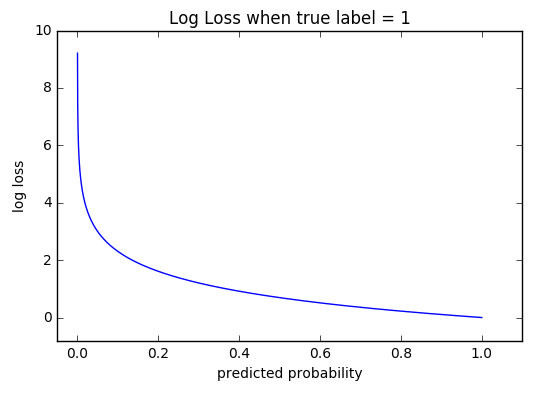

In [10]:
loss_ce = nn.CrossEntropyLoss(reduction='mean')
y_true = torch.tensor(ordinal_enc_NER.transform(data[['Tag']]), dtype=torch.long).view(-1)

y_true_ohe_parfait = torch.tensor(
    pd.get_dummies(y_true).astype(float).replace(0, -1234).to_numpy(),
    dtype=torch.float
)

# -3 est un nombre arbitraire qui affecte à la bonne classe une proba de 5%.
y_true_ohe = torch.tensor(
    pd.get_dummies(y_true).astype(float).replace(0, -3).to_numpy(),
    dtype=torch.float
)

In [11]:
#  Modèle oracle :
y_pred = y_true_ohe_parfait.detach()
print('Loss oracle :', loss_ce(y_pred, y_true))

# Modèle avec une accuracy de 98 %
# Pour rappel, une accuracy en dessous de 96 % est mauvaise !
# → data.Tag.value_counts(normalize=True)
accuracy_souhaitée = 0.98
nb_lignes_à_erroring = int((1 - accuracy_souhaitée) * y_true.shape[0])
y_pred = y_true_ohe.detach()
y_pred[0:nb_lignes_à_erroring, :] = shift_tensor(y_pred[0:nb_lignes_à_erroring, :])
print("Loss d'un modèle satisfaisant :", loss_ce(y_pred, y_true))

# Modèle qui prédit la classe modale : 
classe_modale = data.Tag.value_counts().nlargest(1).index[0]
y_pred = np.full((len(data), num_tag), -3)
y_pred[:, int(ordinal_enc_NER.transform([[classe_modale]]).item())] = 1
y_pred = torch.tensor(y_pred, dtype=torch.float)
print("Loss du modèle qui prédit argcount :", loss_ce(y_pred, y_true))

# Modèle aléatoire :
y_pred = torch.tensor(
    pd.get_dummies(torch.randint(0, num_tag, (len(data),))).astype(float).replace(0, -3).to_numpy(),
    dtype=torch.float
)
print("Loss d'un modèle aléatoire :", loss_ce(y_pred, y_true))

Loss oracle : tensor(0.)
Loss d'un modèle satisfaisant : tensor(0.1160)
Loss du modèle qui prédit argcount : tensor(0.1768)
Loss d'un modèle aléatoire : tensor(2.7005)


## Paramétrage

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [13]:
model = EntityModel(num_tag=num_tag)
model.to(device);

I0626 08:27:39.242717 140151762241344 modeling.py:577] loading archive file data/inputs/models/bert-base-uncased
I0626 08:27:39.248798 140151762241344 modeling.py:598] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

I0626 08:27:45.839415 140151762241344 modeling.py:648] Weights of BertForTokenClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0626 08:27:45.840662 140151762241344 modeling.py:651] Weights from pretrai

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

In [15]:
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [16]:
num_train_steps = int(len(sentences_minitrain) / PARAMS.MODEL.TRAIN_BATCH_SIZE * PARAMS.MODEL.EPOCHS)
print(f"{num_train_steps} batchs vont être envoyés dans le réseau au cours de {PARAMS.MODEL.EPOCHS} epochs.")

optimizer = torch.optim.AdamW(optimizer_parameters, lr=PARAMS.MODEL.LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

3597 batchs vont être envoyés dans le réseau au cours de 4 epochs.


## Entraînement

In [17]:
best_loss = np.inf

pbar = tqdm(range(PARAMS.MODEL.EPOCHS))
for num_epoch, epoch in enumerate(pbar):
    train_loss = train_fn(minitrain_data_loader, model, optimizer,
                          device, scheduler, pbar=pbar, num_epoch=num_epoch)
    
    # On évalue le modèle à la fin de chaque epoch
    test_loss = eval_fn(valid_data_loader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
    
    if test_loss < best_loss:
        torch.save(model.state_dict(), PARAMS.PATHS.MODEL_SAVED)
        best_loss = test_loss

  0%|          | 0/4 [00:00<?, ?it/s]

Batch #0 : loss = 1.175908
Batch #10 : loss = 0.328072
Batch #20 : loss = 0.349201
Batch #30 : loss = 0.235481
Batch #40 : loss = 0.197290
Batch #50 : loss = 0.197902
Batch #60 : loss = 0.246846
Batch #70 : loss = 0.204052
Batch #80 : loss = 0.193391
Batch #90 : loss = 0.185136
Batch #100 : loss = 0.261966
Batch #110 : loss = 0.199818
Batch #120 : loss = 0.200901
Batch #130 : loss = 0.189416
Batch #140 : loss = 0.242348
Batch #150 : loss = 0.256955
Batch #160 : loss = 0.189808
Batch #170 : loss = 0.190499
Batch #180 : loss = 0.181705
Batch #190 : loss = 0.178590
Batch #200 : loss = 0.239938
Batch #210 : loss = 0.171416
Batch #220 : loss = 0.171301
Batch #230 : loss = 0.213909
Batch #240 : loss = 0.171190
Batch #250 : loss = 0.206733
Batch #260 : loss = 0.206354
Batch #270 : loss = 0.199991
Batch #280 : loss = 0.230558
Batch #290 : loss = 0.177015
Batch #300 : loss = 0.182233
Batch #310 : loss = 0.185148
Batch #320 : loss = 0.208867
Batch #330 : loss = 0.207769
Batch #340 : loss = 0.174

KeyboardInterrupt: 

## Prédictions

Utilisons le modèle finetuné pour prédire une nouvelle phrase.

In [9]:
# On désérialise le meilleur modèle enregistré :
model = EntityModel(num_tag=num_tag)
model.load_state_dict(torch.load('data/models/model_trained_en.bin'))

Some weights of the model checkpoint at ../models/camembert-base were not used when initializing CamembertForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at ../models/camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model 

RuntimeError: Error(s) in loading state_dict for EntityModel:
	Missing key(s) in state_dict: "bert.roberta.embeddings.position_ids", "bert.roberta.embeddings.word_embeddings.weight", "bert.roberta.embeddings.position_embeddings.weight", "bert.roberta.embeddings.token_type_embeddings.weight", "bert.roberta.embeddings.LayerNorm.weight", "bert.roberta.embeddings.LayerNorm.bias", "bert.roberta.encoder.layer.0.attention.self.query.weight", "bert.roberta.encoder.layer.0.attention.self.query.bias", "bert.roberta.encoder.layer.0.attention.self.key.weight", "bert.roberta.encoder.layer.0.attention.self.key.bias", "bert.roberta.encoder.layer.0.attention.self.value.weight", "bert.roberta.encoder.layer.0.attention.self.value.bias", "bert.roberta.encoder.layer.0.attention.output.dense.weight", "bert.roberta.encoder.layer.0.attention.output.dense.bias", "bert.roberta.encoder.layer.0.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.0.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.0.intermediate.dense.weight", "bert.roberta.encoder.layer.0.intermediate.dense.bias", "bert.roberta.encoder.layer.0.output.dense.weight", "bert.roberta.encoder.layer.0.output.dense.bias", "bert.roberta.encoder.layer.0.output.LayerNorm.weight", "bert.roberta.encoder.layer.0.output.LayerNorm.bias", "bert.roberta.encoder.layer.1.attention.self.query.weight", "bert.roberta.encoder.layer.1.attention.self.query.bias", "bert.roberta.encoder.layer.1.attention.self.key.weight", "bert.roberta.encoder.layer.1.attention.self.key.bias", "bert.roberta.encoder.layer.1.attention.self.value.weight", "bert.roberta.encoder.layer.1.attention.self.value.bias", "bert.roberta.encoder.layer.1.attention.output.dense.weight", "bert.roberta.encoder.layer.1.attention.output.dense.bias", "bert.roberta.encoder.layer.1.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.1.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.1.intermediate.dense.weight", "bert.roberta.encoder.layer.1.intermediate.dense.bias", "bert.roberta.encoder.layer.1.output.dense.weight", "bert.roberta.encoder.layer.1.output.dense.bias", "bert.roberta.encoder.layer.1.output.LayerNorm.weight", "bert.roberta.encoder.layer.1.output.LayerNorm.bias", "bert.roberta.encoder.layer.2.attention.self.query.weight", "bert.roberta.encoder.layer.2.attention.self.query.bias", "bert.roberta.encoder.layer.2.attention.self.key.weight", "bert.roberta.encoder.layer.2.attention.self.key.bias", "bert.roberta.encoder.layer.2.attention.self.value.weight", "bert.roberta.encoder.layer.2.attention.self.value.bias", "bert.roberta.encoder.layer.2.attention.output.dense.weight", "bert.roberta.encoder.layer.2.attention.output.dense.bias", "bert.roberta.encoder.layer.2.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.2.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.2.intermediate.dense.weight", "bert.roberta.encoder.layer.2.intermediate.dense.bias", "bert.roberta.encoder.layer.2.output.dense.weight", "bert.roberta.encoder.layer.2.output.dense.bias", "bert.roberta.encoder.layer.2.output.LayerNorm.weight", "bert.roberta.encoder.layer.2.output.LayerNorm.bias", "bert.roberta.encoder.layer.3.attention.self.query.weight", "bert.roberta.encoder.layer.3.attention.self.query.bias", "bert.roberta.encoder.layer.3.attention.self.key.weight", "bert.roberta.encoder.layer.3.attention.self.key.bias", "bert.roberta.encoder.layer.3.attention.self.value.weight", "bert.roberta.encoder.layer.3.attention.self.value.bias", "bert.roberta.encoder.layer.3.attention.output.dense.weight", "bert.roberta.encoder.layer.3.attention.output.dense.bias", "bert.roberta.encoder.layer.3.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.3.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.3.intermediate.dense.weight", "bert.roberta.encoder.layer.3.intermediate.dense.bias", "bert.roberta.encoder.layer.3.output.dense.weight", "bert.roberta.encoder.layer.3.output.dense.bias", "bert.roberta.encoder.layer.3.output.LayerNorm.weight", "bert.roberta.encoder.layer.3.output.LayerNorm.bias", "bert.roberta.encoder.layer.4.attention.self.query.weight", "bert.roberta.encoder.layer.4.attention.self.query.bias", "bert.roberta.encoder.layer.4.attention.self.key.weight", "bert.roberta.encoder.layer.4.attention.self.key.bias", "bert.roberta.encoder.layer.4.attention.self.value.weight", "bert.roberta.encoder.layer.4.attention.self.value.bias", "bert.roberta.encoder.layer.4.attention.output.dense.weight", "bert.roberta.encoder.layer.4.attention.output.dense.bias", "bert.roberta.encoder.layer.4.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.4.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.4.intermediate.dense.weight", "bert.roberta.encoder.layer.4.intermediate.dense.bias", "bert.roberta.encoder.layer.4.output.dense.weight", "bert.roberta.encoder.layer.4.output.dense.bias", "bert.roberta.encoder.layer.4.output.LayerNorm.weight", "bert.roberta.encoder.layer.4.output.LayerNorm.bias", "bert.roberta.encoder.layer.5.attention.self.query.weight", "bert.roberta.encoder.layer.5.attention.self.query.bias", "bert.roberta.encoder.layer.5.attention.self.key.weight", "bert.roberta.encoder.layer.5.attention.self.key.bias", "bert.roberta.encoder.layer.5.attention.self.value.weight", "bert.roberta.encoder.layer.5.attention.self.value.bias", "bert.roberta.encoder.layer.5.attention.output.dense.weight", "bert.roberta.encoder.layer.5.attention.output.dense.bias", "bert.roberta.encoder.layer.5.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.5.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.5.intermediate.dense.weight", "bert.roberta.encoder.layer.5.intermediate.dense.bias", "bert.roberta.encoder.layer.5.output.dense.weight", "bert.roberta.encoder.layer.5.output.dense.bias", "bert.roberta.encoder.layer.5.output.LayerNorm.weight", "bert.roberta.encoder.layer.5.output.LayerNorm.bias", "bert.roberta.encoder.layer.6.attention.self.query.weight", "bert.roberta.encoder.layer.6.attention.self.query.bias", "bert.roberta.encoder.layer.6.attention.self.key.weight", "bert.roberta.encoder.layer.6.attention.self.key.bias", "bert.roberta.encoder.layer.6.attention.self.value.weight", "bert.roberta.encoder.layer.6.attention.self.value.bias", "bert.roberta.encoder.layer.6.attention.output.dense.weight", "bert.roberta.encoder.layer.6.attention.output.dense.bias", "bert.roberta.encoder.layer.6.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.6.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.6.intermediate.dense.weight", "bert.roberta.encoder.layer.6.intermediate.dense.bias", "bert.roberta.encoder.layer.6.output.dense.weight", "bert.roberta.encoder.layer.6.output.dense.bias", "bert.roberta.encoder.layer.6.output.LayerNorm.weight", "bert.roberta.encoder.layer.6.output.LayerNorm.bias", "bert.roberta.encoder.layer.7.attention.self.query.weight", "bert.roberta.encoder.layer.7.attention.self.query.bias", "bert.roberta.encoder.layer.7.attention.self.key.weight", "bert.roberta.encoder.layer.7.attention.self.key.bias", "bert.roberta.encoder.layer.7.attention.self.value.weight", "bert.roberta.encoder.layer.7.attention.self.value.bias", "bert.roberta.encoder.layer.7.attention.output.dense.weight", "bert.roberta.encoder.layer.7.attention.output.dense.bias", "bert.roberta.encoder.layer.7.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.7.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.7.intermediate.dense.weight", "bert.roberta.encoder.layer.7.intermediate.dense.bias", "bert.roberta.encoder.layer.7.output.dense.weight", "bert.roberta.encoder.layer.7.output.dense.bias", "bert.roberta.encoder.layer.7.output.LayerNorm.weight", "bert.roberta.encoder.layer.7.output.LayerNorm.bias", "bert.roberta.encoder.layer.8.attention.self.query.weight", "bert.roberta.encoder.layer.8.attention.self.query.bias", "bert.roberta.encoder.layer.8.attention.self.key.weight", "bert.roberta.encoder.layer.8.attention.self.key.bias", "bert.roberta.encoder.layer.8.attention.self.value.weight", "bert.roberta.encoder.layer.8.attention.self.value.bias", "bert.roberta.encoder.layer.8.attention.output.dense.weight", "bert.roberta.encoder.layer.8.attention.output.dense.bias", "bert.roberta.encoder.layer.8.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.8.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.8.intermediate.dense.weight", "bert.roberta.encoder.layer.8.intermediate.dense.bias", "bert.roberta.encoder.layer.8.output.dense.weight", "bert.roberta.encoder.layer.8.output.dense.bias", "bert.roberta.encoder.layer.8.output.LayerNorm.weight", "bert.roberta.encoder.layer.8.output.LayerNorm.bias", "bert.roberta.encoder.layer.9.attention.self.query.weight", "bert.roberta.encoder.layer.9.attention.self.query.bias", "bert.roberta.encoder.layer.9.attention.self.key.weight", "bert.roberta.encoder.layer.9.attention.self.key.bias", "bert.roberta.encoder.layer.9.attention.self.value.weight", "bert.roberta.encoder.layer.9.attention.self.value.bias", "bert.roberta.encoder.layer.9.attention.output.dense.weight", "bert.roberta.encoder.layer.9.attention.output.dense.bias", "bert.roberta.encoder.layer.9.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.9.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.9.intermediate.dense.weight", "bert.roberta.encoder.layer.9.intermediate.dense.bias", "bert.roberta.encoder.layer.9.output.dense.weight", "bert.roberta.encoder.layer.9.output.dense.bias", "bert.roberta.encoder.layer.9.output.LayerNorm.weight", "bert.roberta.encoder.layer.9.output.LayerNorm.bias", "bert.roberta.encoder.layer.10.attention.self.query.weight", "bert.roberta.encoder.layer.10.attention.self.query.bias", "bert.roberta.encoder.layer.10.attention.self.key.weight", "bert.roberta.encoder.layer.10.attention.self.key.bias", "bert.roberta.encoder.layer.10.attention.self.value.weight", "bert.roberta.encoder.layer.10.attention.self.value.bias", "bert.roberta.encoder.layer.10.attention.output.dense.weight", "bert.roberta.encoder.layer.10.attention.output.dense.bias", "bert.roberta.encoder.layer.10.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.10.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.10.intermediate.dense.weight", "bert.roberta.encoder.layer.10.intermediate.dense.bias", "bert.roberta.encoder.layer.10.output.dense.weight", "bert.roberta.encoder.layer.10.output.dense.bias", "bert.roberta.encoder.layer.10.output.LayerNorm.weight", "bert.roberta.encoder.layer.10.output.LayerNorm.bias", "bert.roberta.encoder.layer.11.attention.self.query.weight", "bert.roberta.encoder.layer.11.attention.self.query.bias", "bert.roberta.encoder.layer.11.attention.self.key.weight", "bert.roberta.encoder.layer.11.attention.self.key.bias", "bert.roberta.encoder.layer.11.attention.self.value.weight", "bert.roberta.encoder.layer.11.attention.self.value.bias", "bert.roberta.encoder.layer.11.attention.output.dense.weight", "bert.roberta.encoder.layer.11.attention.output.dense.bias", "bert.roberta.encoder.layer.11.attention.output.LayerNorm.weight", "bert.roberta.encoder.layer.11.attention.output.LayerNorm.bias", "bert.roberta.encoder.layer.11.intermediate.dense.weight", "bert.roberta.encoder.layer.11.intermediate.dense.bias", "bert.roberta.encoder.layer.11.output.dense.weight", "bert.roberta.encoder.layer.11.output.dense.bias", "bert.roberta.encoder.layer.11.output.LayerNorm.weight", "bert.roberta.encoder.layer.11.output.LayerNorm.bias". 
	Unexpected key(s) in state_dict: "bert.bert.embeddings.word_embeddings.weight", "bert.bert.embeddings.position_embeddings.weight", "bert.bert.embeddings.token_type_embeddings.weight", "bert.bert.embeddings.LayerNorm.weight", "bert.bert.embeddings.LayerNorm.bias", "bert.bert.encoder.layer.0.attention.self.query.weight", "bert.bert.encoder.layer.0.attention.self.query.bias", "bert.bert.encoder.layer.0.attention.self.key.weight", "bert.bert.encoder.layer.0.attention.self.key.bias", "bert.bert.encoder.layer.0.attention.self.value.weight", "bert.bert.encoder.layer.0.attention.self.value.bias", "bert.bert.encoder.layer.0.attention.output.dense.weight", "bert.bert.encoder.layer.0.attention.output.dense.bias", "bert.bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.0.intermediate.dense.weight", "bert.bert.encoder.layer.0.intermediate.dense.bias", "bert.bert.encoder.layer.0.output.dense.weight", "bert.bert.encoder.layer.0.output.dense.bias", "bert.bert.encoder.layer.0.output.LayerNorm.weight", "bert.bert.encoder.layer.0.output.LayerNorm.bias", "bert.bert.encoder.layer.1.attention.self.query.weight", "bert.bert.encoder.layer.1.attention.self.query.bias", "bert.bert.encoder.layer.1.attention.self.key.weight", "bert.bert.encoder.layer.1.attention.self.key.bias", "bert.bert.encoder.layer.1.attention.self.value.weight", "bert.bert.encoder.layer.1.attention.self.value.bias", "bert.bert.encoder.layer.1.attention.output.dense.weight", "bert.bert.encoder.layer.1.attention.output.dense.bias", "bert.bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.1.intermediate.dense.weight", "bert.bert.encoder.layer.1.intermediate.dense.bias", "bert.bert.encoder.layer.1.output.dense.weight", "bert.bert.encoder.layer.1.output.dense.bias", "bert.bert.encoder.layer.1.output.LayerNorm.weight", "bert.bert.encoder.layer.1.output.LayerNorm.bias", "bert.bert.encoder.layer.2.attention.self.query.weight", "bert.bert.encoder.layer.2.attention.self.query.bias", "bert.bert.encoder.layer.2.attention.self.key.weight", "bert.bert.encoder.layer.2.attention.self.key.bias", "bert.bert.encoder.layer.2.attention.self.value.weight", "bert.bert.encoder.layer.2.attention.self.value.bias", "bert.bert.encoder.layer.2.attention.output.dense.weight", "bert.bert.encoder.layer.2.attention.output.dense.bias", "bert.bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.2.intermediate.dense.weight", "bert.bert.encoder.layer.2.intermediate.dense.bias", "bert.bert.encoder.layer.2.output.dense.weight", "bert.bert.encoder.layer.2.output.dense.bias", "bert.bert.encoder.layer.2.output.LayerNorm.weight", "bert.bert.encoder.layer.2.output.LayerNorm.bias", "bert.bert.encoder.layer.3.attention.self.query.weight", "bert.bert.encoder.layer.3.attention.self.query.bias", "bert.bert.encoder.layer.3.attention.self.key.weight", "bert.bert.encoder.layer.3.attention.self.key.bias", "bert.bert.encoder.layer.3.attention.self.value.weight", "bert.bert.encoder.layer.3.attention.self.value.bias", "bert.bert.encoder.layer.3.attention.output.dense.weight", "bert.bert.encoder.layer.3.attention.output.dense.bias", "bert.bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.3.intermediate.dense.weight", "bert.bert.encoder.layer.3.intermediate.dense.bias", "bert.bert.encoder.layer.3.output.dense.weight", "bert.bert.encoder.layer.3.output.dense.bias", "bert.bert.encoder.layer.3.output.LayerNorm.weight", "bert.bert.encoder.layer.3.output.LayerNorm.bias", "bert.bert.encoder.layer.4.attention.self.query.weight", "bert.bert.encoder.layer.4.attention.self.query.bias", "bert.bert.encoder.layer.4.attention.self.key.weight", "bert.bert.encoder.layer.4.attention.self.key.bias", "bert.bert.encoder.layer.4.attention.self.value.weight", "bert.bert.encoder.layer.4.attention.self.value.bias", "bert.bert.encoder.layer.4.attention.output.dense.weight", "bert.bert.encoder.layer.4.attention.output.dense.bias", "bert.bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.4.intermediate.dense.weight", "bert.bert.encoder.layer.4.intermediate.dense.bias", "bert.bert.encoder.layer.4.output.dense.weight", "bert.bert.encoder.layer.4.output.dense.bias", "bert.bert.encoder.layer.4.output.LayerNorm.weight", "bert.bert.encoder.layer.4.output.LayerNorm.bias", "bert.bert.encoder.layer.5.attention.self.query.weight", "bert.bert.encoder.layer.5.attention.self.query.bias", "bert.bert.encoder.layer.5.attention.self.key.weight", "bert.bert.encoder.layer.5.attention.self.key.bias", "bert.bert.encoder.layer.5.attention.self.value.weight", "bert.bert.encoder.layer.5.attention.self.value.bias", "bert.bert.encoder.layer.5.attention.output.dense.weight", "bert.bert.encoder.layer.5.attention.output.dense.bias", "bert.bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.5.intermediate.dense.weight", "bert.bert.encoder.layer.5.intermediate.dense.bias", "bert.bert.encoder.layer.5.output.dense.weight", "bert.bert.encoder.layer.5.output.dense.bias", "bert.bert.encoder.layer.5.output.LayerNorm.weight", "bert.bert.encoder.layer.5.output.LayerNorm.bias", "bert.bert.encoder.layer.6.attention.self.query.weight", "bert.bert.encoder.layer.6.attention.self.query.bias", "bert.bert.encoder.layer.6.attention.self.key.weight", "bert.bert.encoder.layer.6.attention.self.key.bias", "bert.bert.encoder.layer.6.attention.self.value.weight", "bert.bert.encoder.layer.6.attention.self.value.bias", "bert.bert.encoder.layer.6.attention.output.dense.weight", "bert.bert.encoder.layer.6.attention.output.dense.bias", "bert.bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.6.intermediate.dense.weight", "bert.bert.encoder.layer.6.intermediate.dense.bias", "bert.bert.encoder.layer.6.output.dense.weight", "bert.bert.encoder.layer.6.output.dense.bias", "bert.bert.encoder.layer.6.output.LayerNorm.weight", "bert.bert.encoder.layer.6.output.LayerNorm.bias", "bert.bert.encoder.layer.7.attention.self.query.weight", "bert.bert.encoder.layer.7.attention.self.query.bias", "bert.bert.encoder.layer.7.attention.self.key.weight", "bert.bert.encoder.layer.7.attention.self.key.bias", "bert.bert.encoder.layer.7.attention.self.value.weight", "bert.bert.encoder.layer.7.attention.self.value.bias", "bert.bert.encoder.layer.7.attention.output.dense.weight", "bert.bert.encoder.layer.7.attention.output.dense.bias", "bert.bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.7.intermediate.dense.weight", "bert.bert.encoder.layer.7.intermediate.dense.bias", "bert.bert.encoder.layer.7.output.dense.weight", "bert.bert.encoder.layer.7.output.dense.bias", "bert.bert.encoder.layer.7.output.LayerNorm.weight", "bert.bert.encoder.layer.7.output.LayerNorm.bias", "bert.bert.encoder.layer.8.attention.self.query.weight", "bert.bert.encoder.layer.8.attention.self.query.bias", "bert.bert.encoder.layer.8.attention.self.key.weight", "bert.bert.encoder.layer.8.attention.self.key.bias", "bert.bert.encoder.layer.8.attention.self.value.weight", "bert.bert.encoder.layer.8.attention.self.value.bias", "bert.bert.encoder.layer.8.attention.output.dense.weight", "bert.bert.encoder.layer.8.attention.output.dense.bias", "bert.bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.8.intermediate.dense.weight", "bert.bert.encoder.layer.8.intermediate.dense.bias", "bert.bert.encoder.layer.8.output.dense.weight", "bert.bert.encoder.layer.8.output.dense.bias", "bert.bert.encoder.layer.8.output.LayerNorm.weight", "bert.bert.encoder.layer.8.output.LayerNorm.bias", "bert.bert.encoder.layer.9.attention.self.query.weight", "bert.bert.encoder.layer.9.attention.self.query.bias", "bert.bert.encoder.layer.9.attention.self.key.weight", "bert.bert.encoder.layer.9.attention.self.key.bias", "bert.bert.encoder.layer.9.attention.self.value.weight", "bert.bert.encoder.layer.9.attention.self.value.bias", "bert.bert.encoder.layer.9.attention.output.dense.weight", "bert.bert.encoder.layer.9.attention.output.dense.bias", "bert.bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.9.intermediate.dense.weight", "bert.bert.encoder.layer.9.intermediate.dense.bias", "bert.bert.encoder.layer.9.output.dense.weight", "bert.bert.encoder.layer.9.output.dense.bias", "bert.bert.encoder.layer.9.output.LayerNorm.weight", "bert.bert.encoder.layer.9.output.LayerNorm.bias", "bert.bert.encoder.layer.10.attention.self.query.weight", "bert.bert.encoder.layer.10.attention.self.query.bias", "bert.bert.encoder.layer.10.attention.self.key.weight", "bert.bert.encoder.layer.10.attention.self.key.bias", "bert.bert.encoder.layer.10.attention.self.value.weight", "bert.bert.encoder.layer.10.attention.self.value.bias", "bert.bert.encoder.layer.10.attention.output.dense.weight", "bert.bert.encoder.layer.10.attention.output.dense.bias", "bert.bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.10.intermediate.dense.weight", "bert.bert.encoder.layer.10.intermediate.dense.bias", "bert.bert.encoder.layer.10.output.dense.weight", "bert.bert.encoder.layer.10.output.dense.bias", "bert.bert.encoder.layer.10.output.LayerNorm.weight", "bert.bert.encoder.layer.10.output.LayerNorm.bias", "bert.bert.encoder.layer.11.attention.self.query.weight", "bert.bert.encoder.layer.11.attention.self.query.bias", "bert.bert.encoder.layer.11.attention.self.key.weight", "bert.bert.encoder.layer.11.attention.self.key.bias", "bert.bert.encoder.layer.11.attention.self.value.weight", "bert.bert.encoder.layer.11.attention.self.value.bias", "bert.bert.encoder.layer.11.attention.output.dense.weight", "bert.bert.encoder.layer.11.attention.output.dense.bias", "bert.bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.11.intermediate.dense.weight", "bert.bert.encoder.layer.11.intermediate.dense.bias", "bert.bert.encoder.layer.11.output.dense.weight", "bert.bert.encoder.layer.11.output.dense.bias", "bert.bert.encoder.layer.11.output.LayerNorm.weight", "bert.bert.encoder.layer.11.output.LayerNorm.bias", "bert.bert.pooler.dense.weight", "bert.bert.pooler.dense.bias". 

In [70]:
i = 423
single_example = test_dataset[i]
print(' '.join(test_dataset.texts[i]))

single_example = {k: single_example[k].unsqueeze(0) for k in single_example}
with torch.no_grad():
    output, loss = model(**single_example)

# Retrait des valeurs qui ne contribuent pas à la loss :
output = output[single_example['mask'] == 1]

predictions_probas = nn.functional.softmax(output, dim=1).detach().squeeze()
predictions_probas, predictions_classes = torch.max(predictions_probas, dim=1)

The minister said the man and a family member were unharmed because they got out of the vehicle just before the blast .


In [71]:
nb_tokens = single_example['mask'].sum().item()
ids = single_example['ids'].squeeze()[:nb_tokens]

pd.DataFrame({
    'token_text': [EntityDataset.tokenizer.decode([token]) for token in ids],
    'token_id': ids,
    'pred_code': predictions_classes,
    'pred_label': ordinal_enc_NER.inverse_transform(predictions_classes.reshape(-1, 1)).squeeze(),
    'y_true': ordinal_enc_NER.inverse_transform(single_example['target_tag'].squeeze()[:nb_tokens].reshape(-1, 1)).squeeze(),
    'class_proba': predictions_probas
}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
token_text,[CLS],the,minister,said,the,man,and,a,family,member,were,unharmed,because,they,got,out,of,the,vehicle,just,before,the,blast,.,[SEP]
token_id,101,1996,2704,2056,1996,2158,1998,1037,2155,2266,2020,28150,2138,2027,2288,2041,1997,1996,4316,2074,2077,1996,8479,1012,102
pred_code,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pred_label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
y_true,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
class_proba,0.999074,0.999998,0.999329,0.499869,0.999999,0.333333,0.998384,0.998224,0.99505,0.999293,0.998228,0.999462,0.998263,0.998102,0.999383,0.99857,0.998542,0.999997,0.998332,0.998324,0.499777,0.999562,0.999582,0.999999,0.999997


In [56]:
sentences_test[i]

['Official',
 'preliminary',
 'results',
 'are',
 'expected',
 'to',
 'be',
 'released',
 'later',
 'Thursday',
 '.']

In [57]:
tag_test[i]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

On remarque que la base d'entraînement est parfois mal labélisée... cf exemples 415, ou 4222. Sur l'exemple `sentences_test[4222]`, on voit que le modèle arrive même à corriger une erreur de labélisation dans l'échantillon test !